# Carga de librerías

**Observación**: La librería, "yfinance" no pertenece a la librería estándar de Python, es necesario instalarla. Para ello abrimos una ventana de comandos y ejecutamos el comando:

```shell
pip install yfinance
```

In [1]:
import yfinance as yf
import pandas as pd
from pathlib import Path

#path_data = Path('/home/ger/GerDrive/Documentos/UNAM/procesos/data')
path_data = Path('/workspaces/procesos/data')


In [4]:
%connect_info

{
  "shell_port": 9002,
  "iopub_port": 9004,
  "stdin_port": 9003,
  "control_port": 9001,
  "hb_port": 9000,
  "ip": "127.0.0.1",
  "key": "8c6e636e-3710-48e0-a26f-7752ce29a161",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v2-419c6cLthp41KNs.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# Valor en riesgo

En finanzas existen multiples medidas de riesgo,  entre las mas populares se encuentra el *Valor en Riesgo* o **VaR**. Esta medida busca estimar una pérdida potencial en un horizonte determinado con cierto nivel de confianza.

Pensémoslo así, si el precio de un activo es $S(t)$ al tiempo $t$, entonces la pérdida o ganancia en la que incurrimos por tener este activo a lo largo de un periodo de longitud $\Delta t$ es:
$$
PnL(t, t+\Delta t) = S(t+\Delta t) - S(t)
$$ 

Visto desde el tiempo $t$ el pnl $PnL(t, t+\Delta t)$ es estocástico, pues el precio $S(t+\Delta_t)$ es de desconocido. Sin embargo podemos estimar cierta pérdida esperada con algún nivel de confianza.

Existen primordialmente, tres métodos para estimar esta pérdida potencial (junto con sus variantes); el método *Delta-Normal*, el *Método histórico* y el *Método Monte Carlo*. A continuación describimos el método histórico, quedara como ejercicio que implementen el método Monte Carlo.

## Método Histórico

Una aproximación muy popular para estimar el VaR, es el *Método Histórico*. La idea fundamental del método consiste en suponer que los precios futuros replicaran el comportamiento del pasado. Lo primero que necesitamos es seleccionar un periodo de tiempo $\Delta t$, típicamente un día, en cuyo caso $\Delta t = 1/252$ o $\Delta t = 1/360$. Otros horizonte populares son 5 y 10 días.

A partir de una serie histórica de $n$ precios: $S(t-i\Delta t)$ con $i= 1, 2, 3, \ldots, n$ (elecciones comunes para $n$ son $n = 252$, $n = 500$ o $n = 1000$). Calculamos una serie de "Shocks": 
$$
Shock(i) =  \frac{S(t-(i-1)\Delta t)}{S(t-i\Delta t)}, \quad i = 1, 2, \ldots, n
$$

Con lo cual generamos una serie de precios simulados:

$$
S_i(t+\Delta t) = S(t) * Shock(i), \quad i = 1, 2, \ldots, n.
$$

Finalmente generamos una distribución simulada de perdidas y ganancias, haciendo:

$$
PnL_i(t, t+\Delta t) = S_i(t+\Delta t) - S(t)\quad i = 1, 2, \ldots, n. 
$$


Una vez generada esta distribución de PnL, seleccionamos un nivel de confianza, ($q = 95\%$, $q = 97.5\%$ y $q = 99\%$ son elecciones populares) y seleccionamos a partir de la serie de PnL el cuantil que acumula el $1-q\%$ de la distribución.  Este cuantil, es precisamente la pérdida esperada que buscamos, el $VaR_{1-q}(\Delta t)$ con nivel de confianza $q$ y horizonte $\Delta t$. Dada la forma en que lo construimos, sabemos que con probabilidad $q$ no incurriremos en  pérdidas mayores a  $VaR_{1-q}(\Delta t)$.


A continuación mostramos la implementación para un portafolio accionario:

### Extraemos historia y calculamos rendimientos.

In [7]:
path_posicion = path_data / 'posicion.xlsx'
#posicion = pd.read_excel(f'{str(path_data)}/posicion.xlsx', 
#                         sheet_name='Hoja1', 
#                         usecols="A:B", 
#                         index_col='Ticker') # Extraemos posicion "path_data": ruta donde tenemos el archivo 'portafolios.xlsx' 


posicion = pd.DataFrame(data={'Ticker':['META', 'C', 'F', 'AMZN', 'AAPL'],'w':[0.2, 0.2, 0.2, 0.2, 0.2]})
posicion.set_index('Ticker', inplace=True)

posicion
simbolos = list(posicion.index)
dias = 500

historia = yf.Tickers(simbolos).history(period=f'{dias +1}d').Close
rendimientos = historia.pct_change()

[*********************100%***********************]  5 of 5 completed


In [6]:
#pd.read_excel(str(path_posicion), engine='openpyxl', sheet_name='Hoja1', usecols="A:B", index_col='Ticker')

posicion = pd.DataFrame(data={'Ticker':['META', 'C', 'F', 'AMZN', 'AAPL'],'w':[0.2, 0.2, 0.2, 0.2, 0.2]})
posicion.set_index('Ticker', inplace=True)

posicion

,w
Ticker,
META,0.2
C,0.2
F,0.2
AMZN,0.2
AAPL,0.2


In [8]:
rendimientos.head()

,AAPL,AMZN,C,F,META
Date,,,,,
2021-06-22,NaN,NaN,NaN,NaN,NaN
2021-06-23,-0.002090,-0.000462,0.010006,0.034205,0.004601
2021-06-24,-0.002169,-0.015623,0.023977,-0.010376,0.007604
2021-06-25,-0.002249,-0.013807,0.003225,-0.004587,-0.005274
2021-06-28,0.012546,0.012474,-0.000559,-0.015141,0.041802


### Histograma de rendimientos

Matplotlib is building the font cache; this may take a moment.


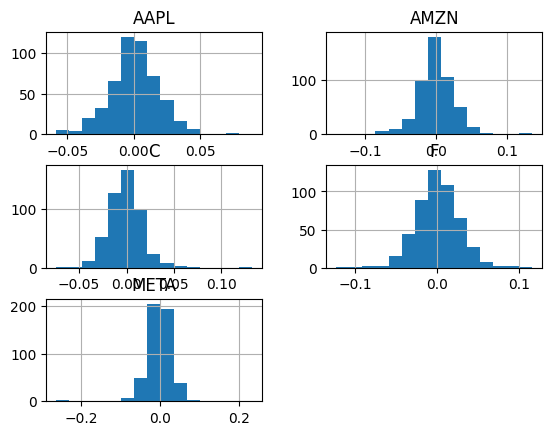

In [9]:
hist_rendimientos = rendimientos.hist(bins=15)

### Matriz de correlaciones

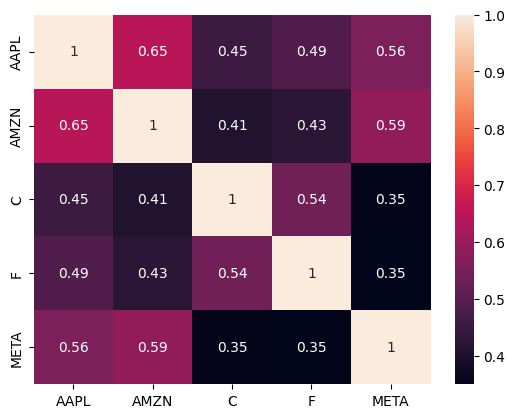

In [10]:
correlaciones = rendimientos.corr()
covarianzas = rendimientos.cov()
vols = rendimientos.std().sort_values(ascending= False)

import seaborn as sns
ax = sns.heatmap(correlaciones, annot=True)

### Comparación de rendimientos acumulados:

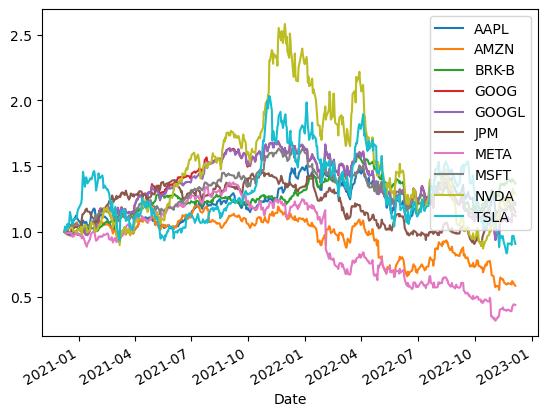

In [62]:
acumulado = (1+rendimientos.fillna(0)).cumprod()
plot_acumulados = acumulado.plot()

In [7]:
ebase

AAPL     146.630005
AMZN      91.010002
BRK-B    310.570007
GOOG      99.870003
GOOGL     99.480003
JPM      131.369995
META     122.430000
MSFT     250.199997
NVDA     166.100006
TSLA     182.449997
Name: 2022-12-05 00:00:00, dtype: float64

### Generamos Shocks y simulación de precios y PnL:

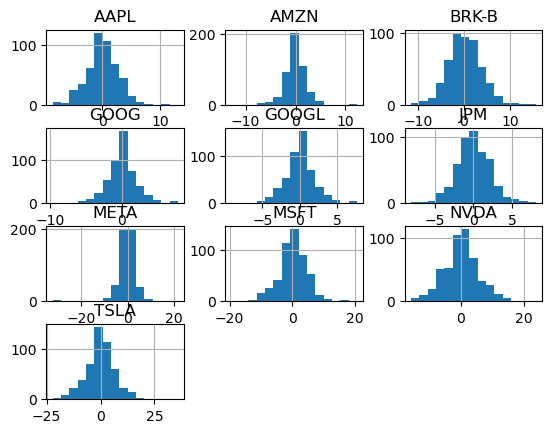

In [6]:
shocks = 1+rendimientos.dropna()   # Estimamos Shocks

# Escenaio base, usualmente los precios de la fecha mas reciente. 
ebase = historia.loc[historia.index.max()] 

#Simulamos los precios y el PnL
precios_simulados = simulacion = shocks.multiply(ebase, axis=1)
pnl_simulado = precios_simulados.sub(ebase, axis=1)

# Calculamos el VaR por instrumento
q = .95
VaR_x_Instrumento = pnl_simulado.quantile(1-q)

#Histogramas del PnL
hist_pnl = pnl_simulado.hist(bins=15)


### Exploramos el VaR por instrumento.

In [10]:
VaR_x_Instrumento.name = 'VaR'
VaR_x_Instrumento.index.name = 'Instrumento'

VaR_x_Instrumento.to_frame()

,VaR
Instrumento,
AAPL,-4.866533
AMZN,-3.370762
BRK-B,-5.719130
GOOG,-3.046557
GOOGL,-3.241911
JPM,-3.537425
META,-5.243855
MSFT,-7.327274
NVDA,-9.297783


### Estimamos el VaR del portafolio

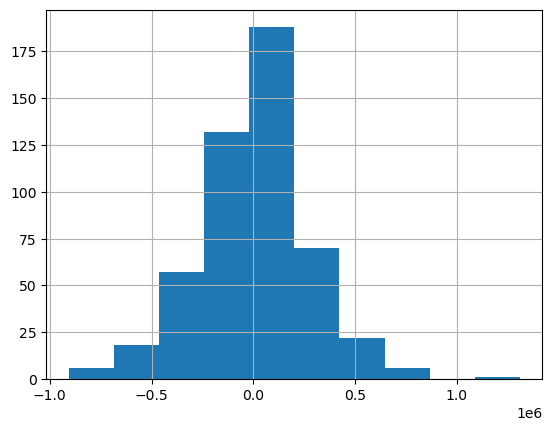

In [11]:
pnl_portafolio = pnl_simulado.multiply(posicion.titulos, axis=1).sum(axis=1) 

hist_pnl_portafolio = pnl_portafolio.hist()

In [13]:
VaR_portafolio = pnl_portafolio.quantile(1-q)

print(f"El VaR del portafolio es:{VaR_portafolio:,.2f}")
print(f"Con proba {q:.2%} no incurriemos en pérdidas superiores.\n")

mtm = float(posicion.multiply(ebase, axis=0).sum())

VaR_porcentual = float(VaR_portafolio /mtm)

print(f"El VaR porcentual del portafolio es {VaR_porcentual:.2%} \ncon mtm:{mtm:,.2f}")

El VaR del portafolio es:-455,813.88
Con proba 95.00% no incurriemos en pérdidas superiores.

El VaR porcentual del portafolio es -2.85% 
con mtm:16,001,100.16


## VaR por Monte Carlo. (TAREA!!! :-))

La idea del VaR por Monte Carlo es en un 80% la misma, la diferencia la encontramos en la forma de simular la serie de precios. $S_i(t+\Delta t)$, $i = 1,2,\ldots, n$.

En este caso nuevamente seleccionamos un horizonte de tiempo $\Delta t$ pero ahora en lugar de calcular shocks a partir de precios históricos, usamos el modelo:


$$
S_i(t+\Delta t) = S(t)\exp\left\{\left(\mu - \frac{1}{2}\sigma^2\right)\Delta t + \sigma \left(W_i(t+\Delta t)-W_i(t)\right)\right\} \quad i = 1,2,\ldots, n
$$

donde $W_i(t+\Delta t)-W_i(t) \sim N(0, \Delta t)$, $i = 1, 2, \ldots,n$, para el  precio de un activo en particular

O bien si hacemos la sustitución de $W_i(t+\Delta t)-W_i(t) \sim N(0, \Delta t)$ por $z_i\sqrt{\Delta t}$,donde $z_i\sim N(0,1)$, entonces:


$$
S_i(t+\Delta t) = S(t)\exp\left\{\left(\mu - \frac{1}{2}\sigma^2\right)\Delta t + \sigma z_i\sqrt{\Delta t} \right\} \quad i = 1,2,\ldots, n
$$

Asi, podemos simular $n$ variables aleatorias normal estándar y usar este modelo para simular $n$ precios diferentes.

Observemos que antes de simular, necesitamos estimar $\mu$ y $\sigma$. En el primer caso $\mu$ es el rendimiento esperado del activo, mientras que $\sigma$ es la volatilidad del activo, es decir la desviación estándar de sus rendimientos.

Adicionalmente, notemos que este mecanismo nos lleva a simular una serie de $n$ precios de un solo activo y en este caso no estamos limitados a $n = 500$ como en el caso de la simulación histórica, en este caso podriamos seleccionar un número $n$ de simulaciones mucho mayor.

Para simular el valor del portafolio, es necesario generar series de precios simuladas para cada una de las acciones que lo componen. En este punto hay que tener en cuenta las correlaciones entre los rendimientos de los activos. No bastara con simular las variables $z_i$ de cada activo de forma independiente. Es necesario correlacionar estas variables. Recomiendo que revisen de que se trata la *descomposición de Cholesky*. 


In [4]:
import pandas as pd
from pathlib import Path


print(Path.home())

for fld in Path.home().iterdir():
    print(fld)


/home/codespace
/home/codespace/.bashrc
/home/codespace/.oh-my-zsh
/home/codespace/.bash_logout
/home/codespace/.config
/home/codespace/.profile
/home/codespace/.zshrc
/home/codespace/.cache
/home/codespace/.ipython
/home/codespace/.vscode-remote
/home/codespace/.docker
/home/codespace/.local
/home/codespace/.rvmrc
/home/codespace/.jupyter
/home/codespace/.ruby
/home/codespace/.rbenv
/home/codespace/java
/home/codespace/.nvs
/home/codespace/.php
/home/codespace/.maven
/home/codespace/.dotnet
/home/codespace/.hugo
/home/codespace/.npm
/home/codespace/nvm
/home/codespace/.python
/home/codespace/.minikube
